Train data shape: (20600, 14), covering dates: 2016-01-01 00:00:00 to 2024-07-01 00:00:00
Test data shape: (400, 14), covering dates: 2024-08-01 00:00:00 to 2024-09-01 00:00:00
Training sequences shape: (18286, 12, 8)
Testing sequences shape: (160, 12, 8)
Epoch [5/50], Loss: 0.0005
Epoch [10/50], Loss: 0.0005
Epoch [15/50], Loss: 0.0005
Epoch [20/50], Loss: 0.0004
Epoch [25/50], Loss: 0.0004
Epoch [30/50], Loss: 0.0004
Epoch [35/50], Loss: 0.0004
Epoch [40/50], Loss: 0.0004
Epoch [45/50], Loss: 0.0004
Epoch [50/50], Loss: 0.0003


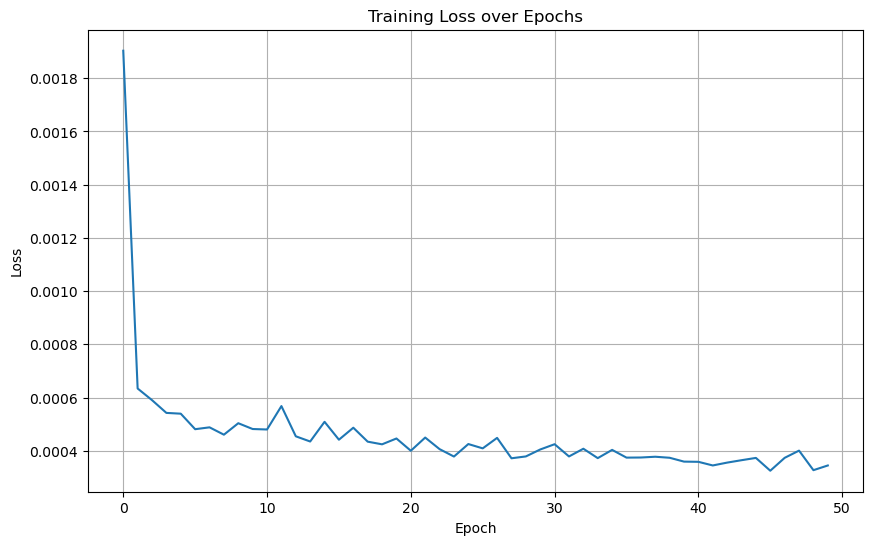


Test Set Performance:
MSE: 209943729007557.88
MAE: 4575675.72
Spearman Rank Correlation: 0.8143

Performance for August 2024:
Top-10 Games:
  Overlap: 70.00% (7 out of 10)
  Precision: 70.00%
  Recall: 70.00%
  F1 Score: 70.00%
  Accuracy: 97.00%
Top-50 Games:
  Overlap: 80.00% (40 out of 50)
  Precision: 80.00%
  Recall: 80.00%
  F1 Score: 80.00%
  Accuracy: 90.00%
Top-100 Games:
  Overlap: 86.00% (86 out of 100)
  Precision: 86.00%
  Recall: 86.00%
  F1 Score: 86.00%
  Accuracy: 86.00%
Top-200 Games:
  Overlap: 80.00% (160 out of 200)
  Precision: 100.00%
  Recall: 100.00%
  F1 Score: 100.00%
  Accuracy: 100.00%

Performance for September 2024:
Top-10 Games:
  Overlap: 70.00% (7 out of 10)
  Precision: 70.00%
  Recall: 70.00%
  F1 Score: 70.00%
  Accuracy: 97.00%
Top-50 Games:
  Overlap: 80.00% (40 out of 50)
  Precision: 80.00%
  Recall: 80.00%
  F1 Score: 80.00%
  Accuracy: 90.00%
Top-100 Games:
  Overlap: 86.00% (86 out of 100)
  Precision: 86.00%
  Recall: 86.00%
  F1 Score: 86.

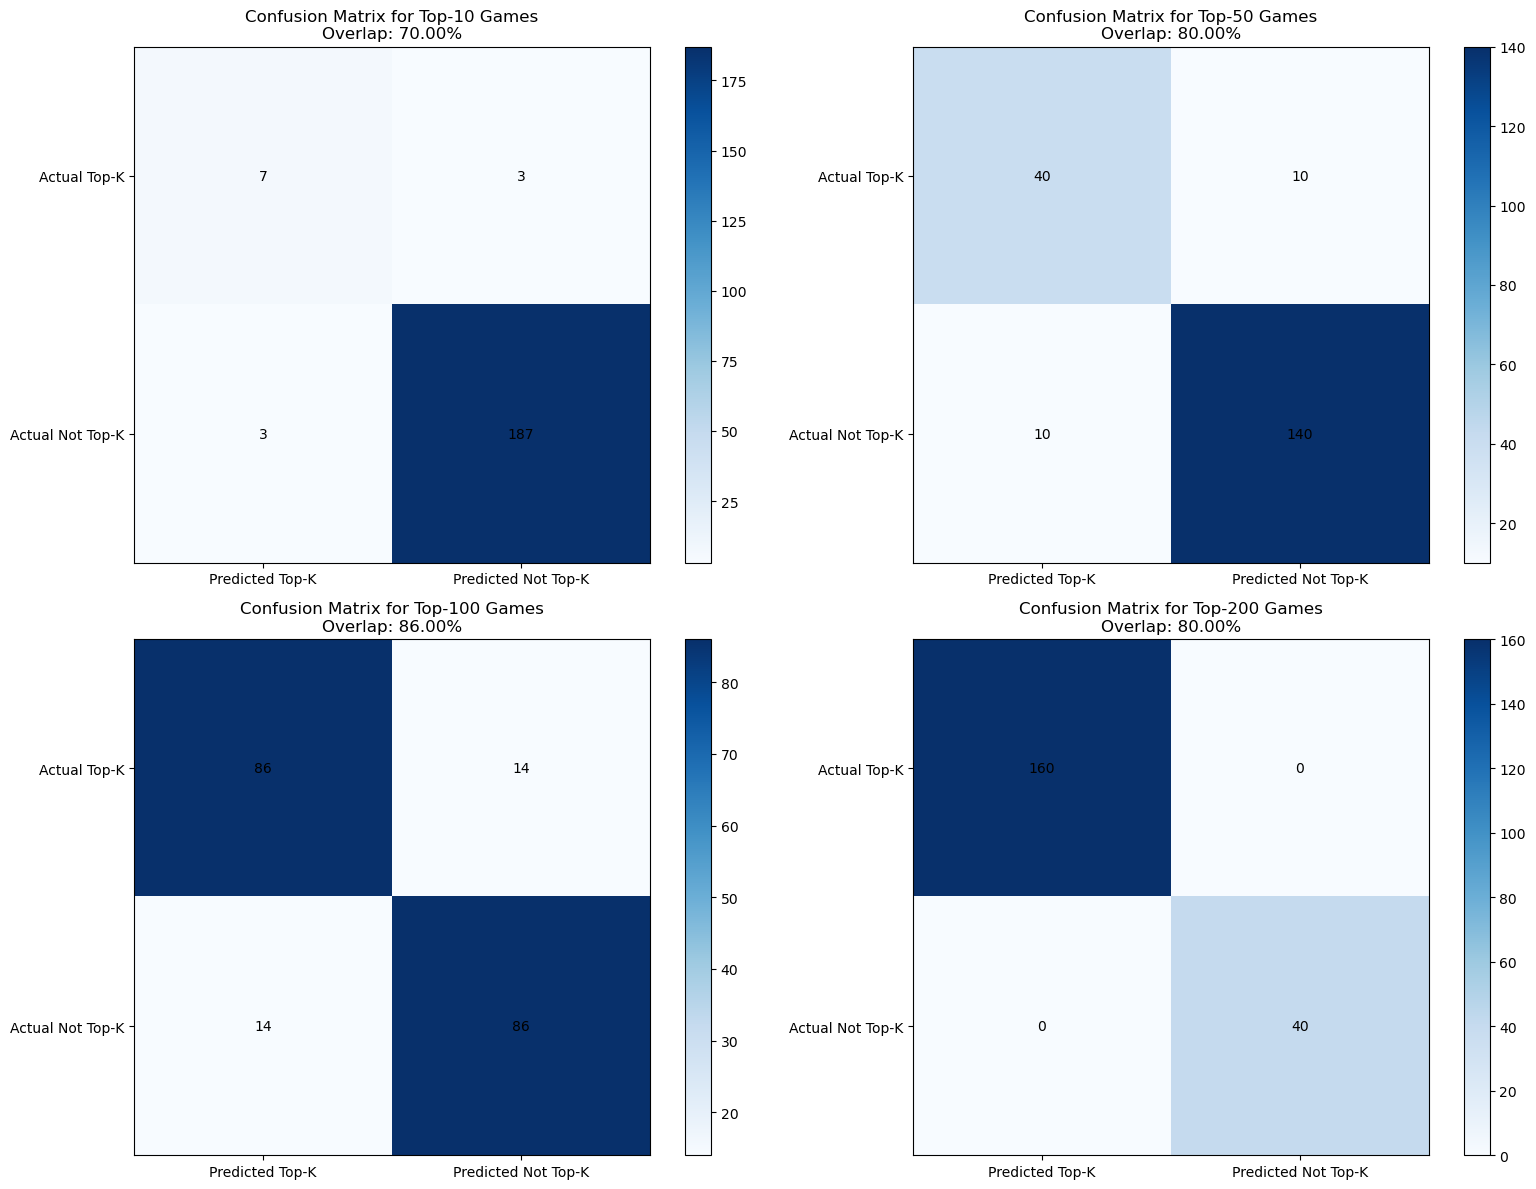


Analysis for September 2024 Top 10 Games:
Correctly Predicted: 7 games
Missed (False Negatives): 3 games
Incorrectly Included (False Positives): 3 games

Top 10 Games by Actual Hours Watched:
                   Game  Rank  Predicted_Rank  Rank_Difference  Hours_watched  \
98        Just Chatting     1             1.0              0.0       0.759967   
99    League of Legends     2             3.0             -1.0       0.289275   
100  Grand Theft Auto V     3             2.0              1.0       0.263855   
101              Dota 2     4             6.0             -2.0       0.191517   
102   World of Warcraft     5            14.0             -9.0       0.165580   
103            VALORANT     6             5.0              1.0       0.164943   
104      Counter-Strike     7             4.0              3.0       0.162694   
105            Fortnite     8            12.0             -4.0       0.131401   
106           Minecraft     9            10.0             -1.0       0.121322 

/var/folders/52/zjjrxnq93bz26zl9gpg17b680000gn/T/ipykernel_7883/112093931.py:479: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([str(abs(int(y))) for y in yticks])


<Figure size 1400x1000 with 0 Axes>

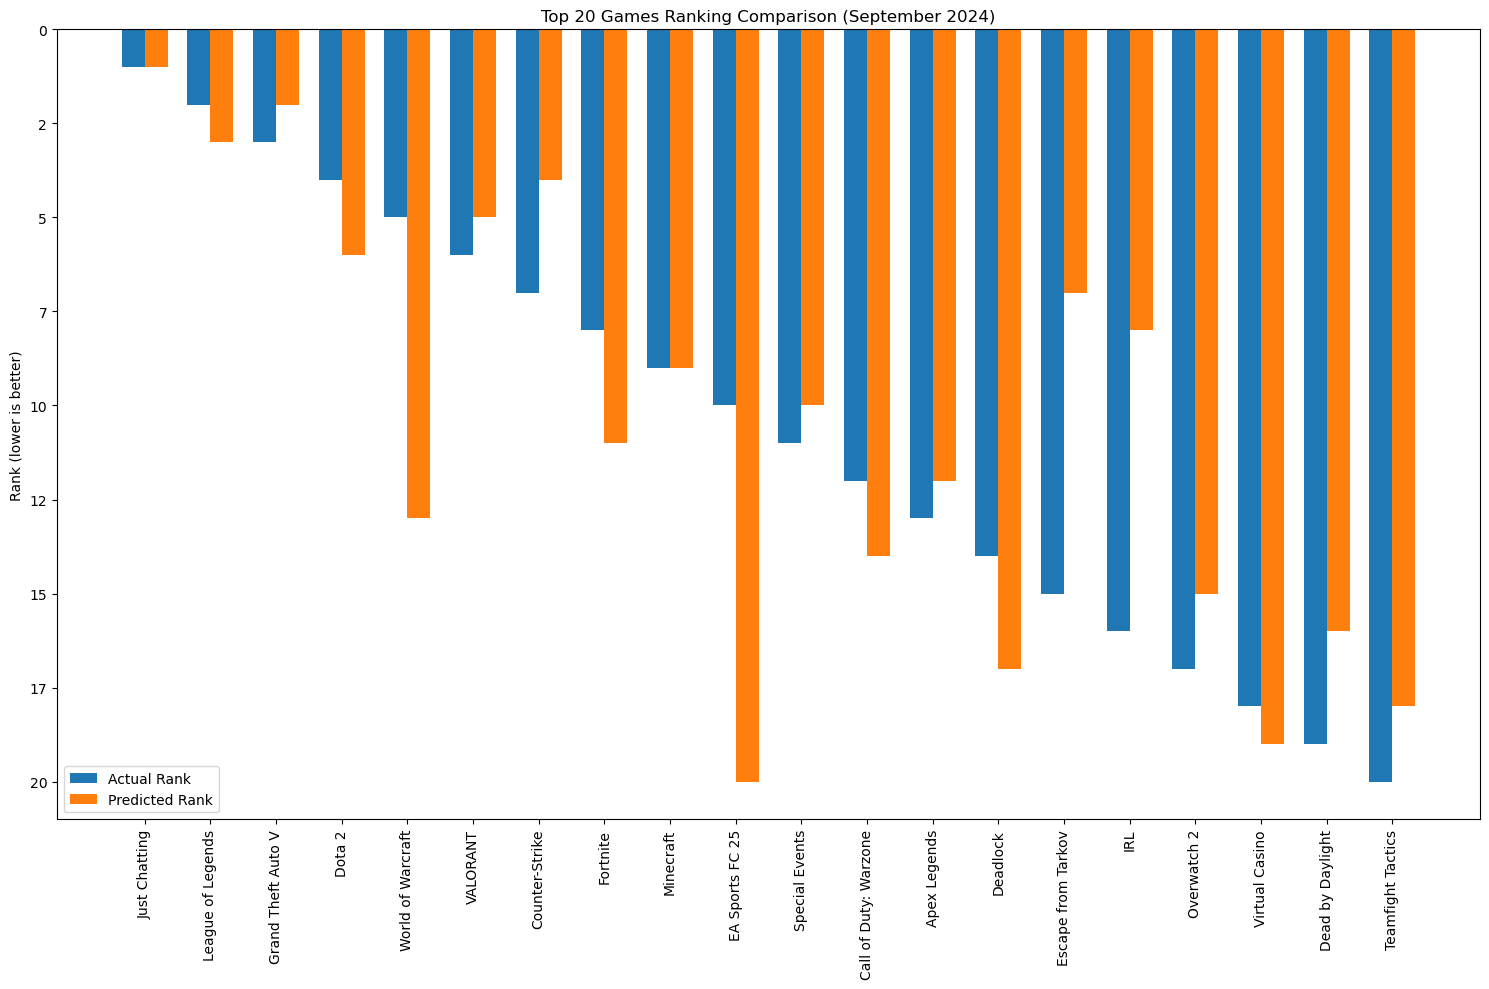

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr

# Load and preprocess data
df = pd.read_csv("Twitch_game_data.csv", encoding="cp1252")
df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(DAY=1))
df = df.sort_values(by=['date']).reset_index(drop=True)

# Encode game names to handle them in the model
game_encoder = LabelEncoder()
df['Game_encoded'] = game_encoder.fit_transform(df['Game'])

# Features and target
predictive_features = [
    'Hours_streamed', 'Peak_viewers', 'Peak_channels', 
    'Streamers', 'Avg_viewers', 'Avg_channels', 'Avg_viewer_ratio',
    'Game_encoded'  # Adding encoded game name as a feature
]
target = 'Hours_watched'  # Predict hours watched, then derive rank from it

# Split data by time - train on earlier months, test on last 2 months
unique_dates = sorted(df['date'].unique())
test_dates = unique_dates[-2:]  
train_dates = unique_dates[:-2]

train_df = df[df['date'].isin(train_dates)].copy()
test_df = df[df['date'].isin(test_dates)].copy()

print(f"Train data shape: {train_df.shape}, covering dates: {train_dates[0]} to {train_dates[-1]}")
print(f"Test data shape: {test_df.shape}, covering dates: {test_dates[0]} to {test_dates[-1]}")

# Scale features
feature_scaler = MinMaxScaler()
train_df[predictive_features] = feature_scaler.fit_transform(train_df[predictive_features])
test_df[predictive_features] = feature_scaler.transform(test_df[predictive_features])

# Create history sequences for each game across months
def create_sequences(dataframe, features, target, max_seq_len=12):
    """Create sequences for each game across months"""
    games = dataframe['Game'].unique()
    all_sequences = []
    all_targets = []
    all_game_ids = []
    
    for game in games:
        game_data = dataframe[dataframe['Game'] == game].sort_values('date')
        if len(game_data) < 2:  # Need at least 2 entries (1 for context, 1 for target)
            continue
            
        for i in range(1, len(game_data)):
            # Get sequence up to current point (max_seq_len)
            seq_start = max(0, i - max_seq_len)
            sequence = game_data.iloc[seq_start:i][features].values
            
            # Pad shorter sequences
            if len(sequence) < max_seq_len:
                pad_length = max_seq_len - len(sequence)
                padding = np.zeros((pad_length, len(features)))
                sequence = np.vstack([padding, sequence])
                
            target_value = game_data.iloc[i][target]
            all_sequences.append(sequence)
            all_targets.append(target_value)
            all_game_ids.append(game)
            
    return np.array(all_sequences), np.array(all_targets), all_game_ids

# Scale target variable (hours watched)
target_scaler = MinMaxScaler()
train_df[[target]] = target_scaler.fit_transform(train_df[[target]])
test_df[[target]] = target_scaler.transform(test_df[[target]])

# Create sequences for transformer model
seq_length = 12  # Up to 12 months of history
X_train, y_train, train_games = create_sequences(train_df, predictive_features, target, seq_length)
X_test, y_test, test_games = create_sequences(test_df, predictive_features, target, seq_length)

print(f"Training sequences shape: {X_train.shape}")
print(f"Testing sequences shape: {X_test.shape}")

# Dataset for transformer model
class GameTransformerDataset(Dataset):
    def __init__(self, sequences, targets):
        self.sequences = torch.tensor(sequences, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32).view(-1, 1)
        
    def __len__(self):
        return len(self.sequences)
        
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

# Transformer Model
class TransformerEncoder(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        
        self.input_embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, seq_length, d_model))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.output_layer = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 1)
        )
        
    def forward(self, x):
        # Input shape: [batch_size, seq_length, feature_dim]
        x = self.input_embedding(x)  # [batch_size, seq_length, d_model]
        x = x + self.positional_encoding
        
        # Create padding mask (assumes zero padding)
        mask = (torch.sum(x, dim=2) != 0).float()
        mask = mask.unsqueeze(-1)
        
        # Apply transformer encoder
        x = self.transformer_encoder(x)  # [batch_size, seq_length, d_model]
        
        # Get the representation of the last element in the sequence
        x = x[:, -1, :]  # [batch_size, d_model]
        
        # Output layer
        x = self.output_layer(x)  # [batch_size, 1]
        return x

# Create datasets and dataloaders
train_dataset = GameTransformerDataset(X_train, y_train)
test_dataset = GameTransformerDataset(X_test, y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
input_dim = X_train.shape[2]  # Number of features
model = TransformerEncoder(input_dim=input_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
num_epochs = 50
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Evaluation
model.eval()
test_predictions = []
test_actuals = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_predictions.extend(outputs.cpu().numpy().flatten().tolist())
        test_actuals.extend(targets.cpu().numpy().flatten().tolist())

# Convert to arrays for easier manipulation
test_predictions = np.array(test_predictions).reshape(-1, 1)
test_actuals = np.array(test_actuals).reshape(-1, 1)

# Inverse transform predictions to get original scale
test_predictions_original = target_scaler.inverse_transform(test_predictions).flatten()
test_actuals_original = target_scaler.inverse_transform(test_actuals).flatten()

# Calculate metrics
mse = mean_squared_error(test_actuals_original, test_predictions_original)
mae = mean_absolute_error(test_actuals_original, test_predictions_original)
spearman_corr, _ = spearmanr(test_actuals_original, test_predictions_original)

print("\nTest Set Performance:")
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"Spearman Rank Correlation: {spearman_corr:.4f}")

# Function to evaluate top-k predictions
def evaluate_top_k_hours(actuals, predictions, games, test_df, k_values=[10, 50, 100, 200]):
    # Create a dataframe with actual and predicted hours watched
    results_df = pd.DataFrame({
        'Game': games,
        'Actual_Hours': actuals,
        'Predicted_Hours': predictions
    })
    
    # Fill NaN values in predicted hours
    results_df['Predicted_Hours'] = results_df['Predicted_Hours'].fillna(0)
    
    # Get the most recent test month to evaluate by date
    recent_dates = test_df['date'].unique()
    
    metrics_by_date = {}
    
    for date in recent_dates:
        date_df = test_df[test_df['date'] == date].copy()
        date_games = set(date_df['Game'])
        
        # Filter results to only include games in this month
        date_results = results_df[results_df['Game'].isin(date_games)].copy()
        
        # Sort by actual and predicted hours (descending)
        actual_sorted = date_results.sort_values('Actual_Hours', ascending=False)
        predicted_sorted = date_results.sort_values('Predicted_Hours', ascending=False)
        
        # Calculate metrics for each k
        date_metrics = {}
        for k in k_values:
            actual_top_k = set(actual_sorted.head(k)['Game'])
            predicted_top_k = set(predicted_sorted.head(k)['Game'])
            
            # Calculate confusion matrix values
            TP = len(actual_top_k.intersection(predicted_top_k))
            FP = len(predicted_top_k - actual_top_k)
            FN = len(actual_top_k - predicted_top_k)
            TN = len(date_games) - (TP + FP + FN)
            
            # Calculate metrics
            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            accuracy = (TP + TN) / (TP + TN + FP + FN)
            
            date_metrics[k] = {
                'TP': TP,
                'FP': FP,
                'FN': FN,
                'TN': TN,
                'Precision': precision,
                'Recall': recall,
                'F1': f1,
                'Accuracy': accuracy,
                'Overlap': TP / k if k > 0 else 0
            }
        
        metrics_by_date[date] = date_metrics
    
    return metrics_by_date

# Evaluate top-k performance using original scale values
k_values = [10, 50, 100, 200]
performance_metrics = evaluate_top_k_hours(
    test_actuals_original, test_predictions_original, test_games, test_df, k_values)

# Print performance metrics

# Print performance metrics
for date, metrics in performance_metrics.items():
    print(f"\nPerformance for {date.strftime('%B %Y')}:")
    for k, k_metrics in metrics.items():
        print(f"Top-{k} Games:")
        print(f"  Overlap: {k_metrics['Overlap']:.2%} ({k_metrics['TP']} out of {k})")
        print(f"  Precision: {k_metrics['Precision']:.2%}")
        print(f"  Recall: {k_metrics['Recall']:.2%}")
        print(f"  F1 Score: {k_metrics['F1']:.2%}")
        print(f"  Accuracy: {k_metrics['Accuracy']:.2%}")

# Visualize confusion matrices for the most recent month
most_recent_date = max(performance_metrics.keys())
most_recent_metrics = performance_metrics[most_recent_date]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, k in enumerate(k_values):
    metrics = most_recent_metrics[k]
    cm = np.array([[metrics['TP'], metrics['FP']], 
                   [metrics['FN'], metrics['TN']]])
    
    ax = axes[i]
    im = ax.imshow(cm, cmap='Blues')
    
    for i_row in range(2):
        for i_col in range(2):
            ax.text(i_col, i_row, f"{cm[i_row, i_col]}", 
                    ha="center", va="center", color="black")
    
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Predicted Top-K', 'Predicted Not Top-K'])
    ax.set_yticklabels(['Actual Top-K', 'Actual Not Top-K'])
    ax.set_title(f"Confusion Matrix for Top-{k} Games\nOverlap: {metrics['Overlap']:.2%}")
    plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

# Create a detailed analysis of top 10 predictions
def analyze_top_10(test_df, predictions, games, most_recent_date):
    # Get the most recent month's data
    recent_df = test_df[test_df['date'] == most_recent_date].copy()
    
    # Create results dataframe
    results = pd.DataFrame({
        'Game': games,
        'Predicted_Rank': predictions
    })
    
    # Merge with actual data
    merged = recent_df[['Game', 'Rank', 'Hours_watched']].merge(
        results, on='Game', how='inner'
    )
    merged.rename(columns={'Rank': 'Actual_Rank'}, inplace=True)
    
    # Sort by actual rank to get top 10
    top10 = merged.sort_values('Actual_Rank').head(10).copy()
    
    # Calculate rank difference
    top10['Rank_Difference'] = top10['Actual_Rank'] - top10['Predicted_Rank']
    
    # Get predicted top 10
    predicted_top10 = merged.sort_values('Predicted_Rank').head(10)
    
    # Calculate overlaps
    actual_top10_games = set(top10['Game'])
    predicted_top10_games = set(predicted_top10['Game'])
    
    correct = actual_top10_games.intersection(predicted_top10_games)
    missed = actual_top10_games - predicted_top10_games
    false_positives = predicted_top10_games - actual_top10_games
    
    print(f"\nAnalysis for {most_recent_date.strftime('%B %Y')} Top 10 Games:")
    print(f"Correctly Predicted: {len(correct)} games")
    print(f"Missed (False Negatives): {len(missed)} games")
    print(f"Incorrectly Included (False Positives): {len(false_positives)} games")
    
    print("\nTop 10 Games by Actual Rank:")
    print(top10[['Game', 'Actual_Rank', 'Predicted_Rank', 'Rank_Difference', 'Hours_watched']])
    
    return top10, predicted_top10

# Create function to analyze top 10 games based on hours watched
def analyze_top_10_hours(test_df, predictions, games, most_recent_date):
    # Get the most recent month's data
    recent_df = test_df[test_df['date'] == most_recent_date].copy()
    
    # Create results dataframe with game names and predicted hours
    results = pd.DataFrame({
        'Game': games,
        'Predicted_Hours': predictions
    })
    
    # Merge with actual data
    merged = recent_df[['Game', 'Rank', 'Hours_watched']].merge(
        results, on='Game', how='inner'
    )
    
    # Fill NaN values in predicted hours
    merged['Predicted_Hours'] = merged['Predicted_Hours'].fillna(0)
    
    # Calculate predicted rank based on predicted hours (descending order)
    merged['Predicted_Rank'] = merged['Predicted_Hours'].rank(ascending=False, method='min').astype(float)
    
    # Sort by actual hours watched to get top 10
    top10 = merged.sort_values('Hours_watched', ascending=False).head(10).copy()
    
    # Calculate rank difference
    top10['Rank_Difference'] = top10['Rank'] - top10['Predicted_Rank']
    
    # Get predicted top 10
    predicted_top10 = merged.sort_values('Predicted_Hours', ascending=False).head(10)
    
    # Calculate overlaps
    actual_top10_games = set(top10['Game'])
    predicted_top10_games = set(predicted_top10['Game'])
    
    correct = actual_top10_games.intersection(predicted_top10_games)
    missed = actual_top10_games - predicted_top10_games
    false_positives = predicted_top10_games - actual_top10_games
    
    print(f"\nAnalysis for {most_recent_date.strftime('%B %Y')} Top 10 Games:")
    print(f"Correctly Predicted: {len(correct)} games")
    print(f"Missed (False Negatives): {len(missed)} games")
    print(f"Incorrectly Included (False Positives): {len(false_positives)} games")
    
    print("\nTop 10 Games by Actual Hours Watched:")
    print(top10[['Game', 'Rank', 'Predicted_Rank', 'Rank_Difference', 'Hours_watched', 'Predicted_Hours']])
    
    return top10, predicted_top10

# Inverse transform predictions to get original scale
test_predictions_original = target_scaler.inverse_transform(
    np.array(test_predictions).reshape(-1, 1)).flatten()
test_actuals_original = target_scaler.inverse_transform(
    np.array(test_actuals).reshape(-1, 1)).flatten()

# Analyze top 10 games for the most recent month
top10_actual, top10_predicted = analyze_top_10_hours(
    test_df, test_predictions_original, test_games, most_recent_date
)

# Visualize top 20 games comparison
plt.figure(figsize=(14, 10))
top20_games = test_df[test_df['date'] == most_recent_date].sort_values('Hours_watched', ascending=False).head(20)
game_names = top20_games['Game'].tolist()

# Create a dataframe with both actual and predicted hours
results_df = pd.DataFrame({
    'Game': test_games,
    'Predicted_Hours': test_predictions_original
})

# Merge with actual data
merged_top20 = top20_games.merge(results_df, on='Game', how='left')

# Handle NaN values in predicted hours
merged_top20['Predicted_Hours'] = merged_top20['Predicted_Hours'].fillna(0)

# Calculate predicted rank based on predicted hours (handle NaN safely)
merged_top20['Predicted_Rank'] = merged_top20['Predicted_Hours'].rank(ascending=False, method='min', na_option='bottom').astype(float)

# Create properly oriented bar chart
x = np.arange(len(game_names))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 10))
# Use negative ranks for plotting, then use absolute values for labels
rects1 = ax.bar(x - width/2, -merged_top20['Rank'], width, label='Actual Rank')
rects2 = ax.bar(x + width/2, -merged_top20['Predicted_Rank'], width, label='Predicted Rank')

# Customize y-axis to show positive rank values
ax.set_ylabel('Rank (lower is better)')
ax.set_title(f'Top 20 Games Ranking Comparison ({most_recent_date.strftime("%B %Y")})')
ax.set_xticks(x)
ax.set_xticklabels(game_names, rotation=90)

# Format y-axis to show positive values
yticks = ax.get_yticks()
ax.set_yticklabels([str(abs(int(y))) for y in yticks])

ax.legend()

plt.tight_layout()
plt.show()

# Analyze rank correlation with the exact same approach as the provided code
def analyze_rank_correlation_simple(test_df, predictions, games, most_recent_date):
    # Get the most recent month's data
    recent_df = test_df[test_df['date'] == most_recent_date].copy()
    
    # Create results dataframe with actual and predicted hours
    results_df = pd.DataFrame({
        'Game': games,
        'Predicted_Hours': predictions
    })
    
    # Merge with actual data to get actual hours
    merged = recent_df[['Game', 'Hours_watched']].merge(
        results_df, on='Game', how='inner'
    )
    
    # Fill any NaN values
    merged['Predicted_Hours'] = merged['Predicted_Hours'].fillna(0)
    
    # Sort by actual hours and assign ranks - this is exactly like the code provided
    top_200_df = merged.sort_values('Hours_watched', ascending=False).head(200).copy()
    top_200_df['Actual_Rank'] = np.arange(1, 201)
    
    # Sort by predicted hours and assign ranks - this is exactly like the code provided
    top_200_df = top_200_df.sort_values('Predicted_Hours', ascending=False).reset_index(drop=True)
    top_200_df['Predicted_Rank'] = np.arange(1, 201)
    
    # Calculate Spearman correlation
    spearman_corr, _ = spearmanr(top_200_df['Actual_Rank'], top_200_df['Predicted_Rank'])
    
    # Create visualization
    plt.figure(figsize=(8, 6))
    plt.scatter(top_200_df['Actual_Rank'], top_200_df['Predicted_Rank'], alpha=0.7)
    plt.plot([1, 200], [1, 200], 'r--')
    plt.xlabel('Actual Rank')
    plt.ylabel('Predicted Rank')
    plt.title(f'Actual vs Predicted Top 200 Game Rankings (Spearman: {spearman_corr:.4f})')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()
    
    return top_200_df, spearman_corr